In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline

from skimage.io import imread, imshow
from skimage.transform import resize

# Don't Show Warning Messages
import warnings
warnings.filterwarnings('ignore')

In [2]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3

In [3]:
import os

input_dir = '/content/drive/MyDrive/flower102_dataset/images/'
target_dir = '/content/drive/MyDrive/flower102_binary_masks'
img_size = (160, 160)
num_classes = 3
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".jpg") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 8200
/content/drive/MyDrive/flower102_dataset/images/image_00001.jpg | /content/drive/MyDrive/flower102_binary_masks/segmim_00001.jpg
/content/drive/MyDrive/flower102_dataset/images/image_00002.jpg | /content/drive/MyDrive/flower102_binary_masks/segmim_00002.jpg
/content/drive/MyDrive/flower102_dataset/images/image_00003.jpg | /content/drive/MyDrive/flower102_binary_masks/segmim_00003.jpg
/content/drive/MyDrive/flower102_dataset/images/image_00004.jpg | /content/drive/MyDrive/flower102_binary_masks/segmim_00004.jpg
/content/drive/MyDrive/flower102_dataset/images/image_00005.jpg | /content/drive/MyDrive/flower102_binary_masks/segmim_00005.jpg
/content/drive/MyDrive/flower102_dataset/images/image_00006.jpg | /content/drive/MyDrive/flower102_binary_masks/segmim_00006.jpg
/content/drive/MyDrive/flower102_dataset/images/image_00007.jpg | /content/drive/MyDrive/flower102_binary_masks/segmim_00007.jpg
/content/drive/MyDrive/flower102_dataset/images/image_00008.jpg | /conten

In [ ]:
binary_mask_dir = '/content/drive/MyDrive/flower102_binary_masks/'
for filename in os.listdir(target_dir):
    img = cv2.imread(os.path.join(target_dir, filename), cv2.IMREAD_GRAYSCALE)
    th, img_bi = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU)
    plt.imsave(binary_mask_dir +filename, img_bi, cmap='gray')   

In [4]:
X_train = np.zeros((len(input_img_paths), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

y_train = np.zeros((len(input_img_paths), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

In [5]:
for i, image_id in enumerate(input_img_paths):
    
    path_image =  image_id
    
    # read the image using skimage
    image = imread(path_image)
    # resize the image
    image = resize(image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    # use np.expand dims to add a channel axis so the shape becomes (IMG_HEIGHT, IMG_WIDTH, 3)
    #image = np.expand_dims(image, axis=-1)
    
    # insert the image into X_train
    X_train[i] = image
    
X_train.shape

(8200, 128, 128, 3)

In [ ]:
for i, mask_id in enumerate(target_img_paths):
    print(i)
    path_mask = mask_id
    
    # read the image using skimage
    mask = imread(path_mask, as_gray=True)
    
    # resize the image
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    # use np.expand dims to add a channel axis so the shape becomes (IMG_HEIGHT, IMG_WIDTH, 1)
    mask = np.expand_dims(mask, axis=-1)
    
    # insert the image into Y_Train
    y_train[i] = mask

y_train.shape

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.05, random_state= 8) 

In [9]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

In [10]:
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])

model.compile(optimizer='adam', loss='binary_crossentropy')

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

In [11]:
filepath = "model.h5"

earlystopper = EarlyStopping(patience=5, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')

callbacks_list = [earlystopper, checkpoint]

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=128, epochs=50, 
                    callbacks=callbacks_list)

Epoch 1/50
61/61 [==============================] - ETA: 0s - loss: 0.4444
Epoch 1: val_loss improved from inf to 0.45774, saving model to model.h5
61/61 [==============================] - 41s 362ms/step - loss: 0.4444 - val_loss: 0.4577
Epoch 2/50
61/61 [==============================] - ETA: 0s - loss: 0.3795
Epoch 2: val_loss improved from 0.45774 to 0.38363, saving model to model.h5
61/61 [==============================] - 18s 290ms/step - loss: 0.3795 - val_loss: 0.3836
Epoch 3/50
61/61 [==============================] - ETA: 0s - loss: 0.3703
Epoch 3: val_loss improved from 0.38363 to 0.36488, saving model to model.h5
61/61 [==============================] - 18s 291ms/step - loss: 0.3703 - val_loss: 0.3649
Epoch 4/50
61/61 [==============================] - ETA: 0s - loss: 0.3615
Epoch 4: val_loss did not improve from 0.36488
61/61 [==============================] - 18s 291ms/step - loss: 0.3615 - val_loss: 0.3821
Epoch 5/50
61/61 [==============================] - ETA: 0s - loss

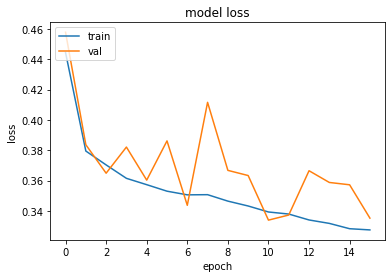

In [48]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [22]:
import cv2
def prepare(img):
    IMG_SIZE = 128
    #img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    new_array = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

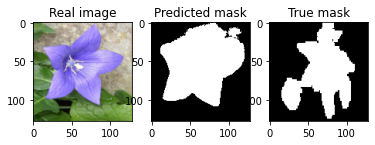

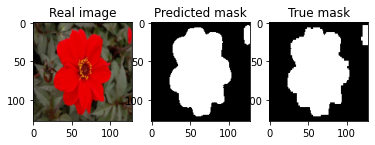

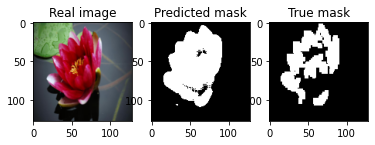

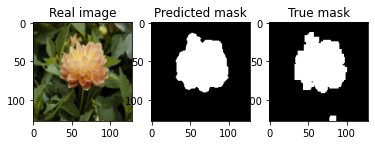

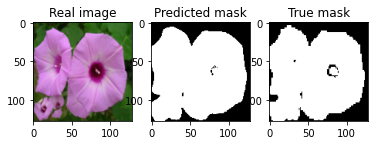

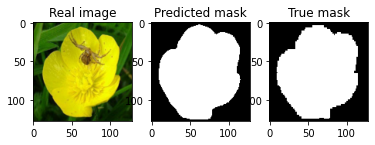

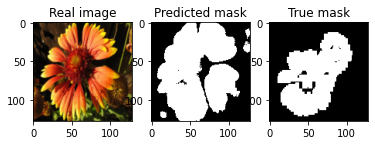

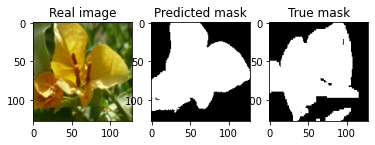

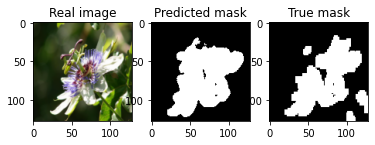

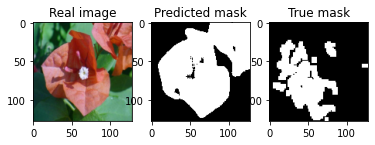

In [46]:
import random
randomlist = random.sample(range(0, len(X_val)), 10)
model.load_weights('model.h5')
for i in randomlist:
    predicted_mask = model.predict(prepare(X_val[i]))
    predicted_mask = (predicted_mask >= 0.5).astype(np.uint8)
    true_mask = y_val[i]
    f, axarr = plt.subplots(1, 3)
    axarr[0].imshow(prepare(X_val[i]).reshape(128, 128, 3))
    axarr[0].title.set_text('Real image')
    axarr[1].imshow(predicted_mask.reshape(128, 128), cmap='gray')
    axarr[1].title.set_text('Predicted mask')
    axarr[2].imshow(true_mask.reshape(128, 128), cmap='gray')
    axarr[2].title.set_text('True mask')